<a href="https://colab.research.google.com/github/justinb4003/4003colab/blob/main/Trajectory_Tracking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import requests
import cv2 as cv
import math as m
import pandas as pd

from skimage.metrics import structural_similarity

max_v_pixels_per_frame = 12

# Measurd 252 pixels to cover a 41cm wide cement block in the background
pixel_per_cm = 252 / 41
pixel_per_m = pixel_per_cm * 100


def output_data(screen_positions, screen_timestamps, outfile):
    p1 = screen_positions[0]
    out_df = pd.DataFrame(
        columns=['screenx', 'screeny',
                 'ms', 'seconds',
                 'xpos', 'ypos',
                 ]
    )
    out_df.ms = screen_timestamps
    out_df.seconds = [ms/1000 for ms in screen_timestamps]
    out_df.screenx = [p[0] for p in screen_positions]
    out_df.screeny = [p[1] for p in screen_positions]
    out_df.screenx -= p1[0]
    out_df.screeny -= p1[1]
    out_df.screenx *= -1.0
    out_df.screeny *= -1.0
    out_df.xpos = out_df.screenx / pixel_per_m
    out_df.ypos = out_df.screeny / pixel_per_m
    out_df.to_csv(outfile)


In [11]:
# From Google Drive if you set a video file to the permisions where anyone
# with the link can view it, and copy that link, it will look someting like
# this: https://drive.google.com/file/d/1n2KMZufOAUqGxNuKcIYNx-E1fwQphRJv/view?usp=sharing

# We grab the identifier after file/d/ and before the next / from that URL
# and make a list of them. These are the files we'll process.
video_files = [
    '1n2KMZufOAUqGxNuKcIYNx-E1fwQphRJv',
]
for idx, vf in enumerate(video_files):
    outfile = f"video{idx}.mp4"
    print(idx, vf)
    resp = requests.get(
        f"https://drive.google.com/uc?export=download&confirm=yes&id={vf}"
    )
    with open(outfile, 'wb') as f:
        f.write(resp.content)


0 1n2KMZufOAUqGxNuKcIYNx-E1fwQphRJv


In [14]:
# Code is built assuming video is trimmed down to only the parts we are
# concerned with. The first frame will be the 'reference' frame that we compare
# others to
skip_frames = 1
# Coordinates of where our area of interest is
min_x, max_x = 175, 1220
min_y, max_y = 30, 350
bbox = (min_x, min_y, max_x-min_x, max_y-min_y)

for idx, vf in enumerate(video_files):
    infile = f'video{idx}.mp4'
    print(infile)
    outfile = infile.replace('mp4', 'csv')
    pngfile = infile.replace('mp4', 'png')
    # Open the video file with OpenCV
    video = cv.VideoCapture(filename=infile)
    last_frame = None
    # Read in a number of frames and keep the last one as our reference frame
    for x in range(skip_frames):
        _, orig_frame = video.read()

    orig_frame = cv.cvtColor(orig_frame, cv.COLOR_BGR2GRAY)
    last_known_pos = [None, None]
    sphere_screen_pos = []
    sphere_timestamps = []
    frame_count = 0
    begin_ts = None
    # Now we loop through the rest of the frames
    while True:
        _, image = video.read()
        # If we didn't get a frame, we're at the end of the video, so break
        # out of the loop
        if not _:
            break
        # Get the time in milliseconds from the video for the first frame
        if begin_ts is None:
            ms = video.get(cv.CAP_PROP_POS_MSEC)
            begin_ts = ms
        frame_count += 1
        # print(f'Frame: {frame_count}')
        ms = video.get(cv.CAP_PROP_POS_MSEC)
        video_ts = ms-begin_ts
        # Convert from color to grayscale. The structural_similarity()
        # function requires grayscale images
        curr_frame = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
        if last_frame is not None:
            (score, diff) = structural_similarity(orig_frame, curr_frame,
                                                  full=True)
            # white out anything that isn't in our area of interest
            diff = (diff * 255).astype("uint8")
            # convert to black/white
            ret, thresh = cv.threshold(diff, 127, 255, 0)
            # now find contours, aka shapes or blobs within that black and
            # white image. This will probably lock in around our game piece
            contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE,
                                                  cv.CHAIN_APPROX_SIMPLE)
            good_contours = []
            bad_contours = []
            for c in contours:
                # Momenets will give us the center of the contour and some
                # stats about it
                M = cv.moments(c)
                # This is the area of the countour in pixels
                area = M["m00"]
                # Reject really large or small ones
                if area > 900000:  # What is this thing!?
                    continue
                if area < 100:
                    continue
                # Find the center X and Y of the contour/game piece
                cX = int(M["m10"] / area)
                cY = int(M["m01"] / area)
                pos = [cX, cY]
                # Check if the center of it is within our search box
                if cX >= min_x and cX <= max_x and cY >= min_y and cY <= max_y:
                    # If so we'll snap a polygon around the countour and
                    # see how many sized it has. If it's 8-20, it's probably
                    # a circle
                    approx = cv.approxPolyDP(c, 0.01*cv.arcLength(c, True),
                                             True)
                    if None not in last_known_pos:
                        dist = m.dist(last_known_pos, pos)
                    else:
                        dist = max_v_pixels_per_frame + 1

                    # If it's circular enough or close enough to the last
                    # known position, we'll keep it and count it as valid.
                    if ((len(approx) > 8 and len(approx) < 21)
                        or
                       (dist <= max_v_pixels_per_frame)):
                        good_contours.append(c)
                        sphere_screen_pos.append(pos)
                        sphere_timestamps.append(video_ts)
                        # Draw where we saw it on the image
                        cv.circle(image, (cX, cY), 10, (255, 0, 255), -1)
                    else:
                        bad_contours.append(c)

            # If we only came out of that with one good contour, we'll assume
            # that's our game piece and update our last known position
            if len(good_contours) == 1:
                last_known_pos = [cX, cY]
            # cv.drawContours(image, good_contours, -1, (0, 255, 0), 3)

            # We can draw the bad contours in red, so we see what was rejected
            cv.drawContours(image, bad_contours, -1, (0, 0, 255), 3)
            # Now draw our circles on the image where detections were made
            for pos in sphere_screen_pos:
                cv.circle(image, pos, 5, (255, 0, 000), 2)

            # Draw box around our area of interest / bounding box
            p1 = (int(bbox[0]), int(bbox[1]))
            p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
            cv.rectangle(image, p1, p2, (0, 255, 0), 10)
            last_image = image.copy()
            # cv.imwrite('test.png', image)
        last_frame = curr_frame.copy()
    video.release()
    cv.imwrite(pngfile, last_image)
    output_data(sphere_screen_pos, sphere_timestamps, outfile)


video0.mp4


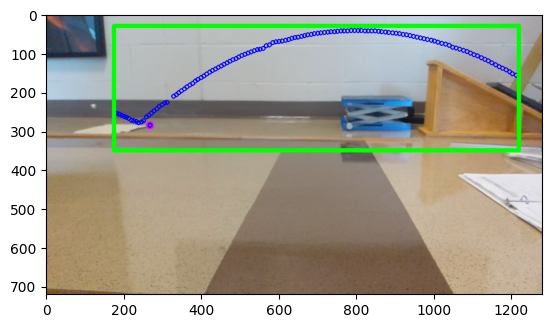

In [13]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('video0.png')
plt.imshow(img)